In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import os, sys
import string
from collections import Counter
import warnings
import random
import re
import seaborn as sns

In [2]:
# Loading some sklearn packaces for modelling.

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics import f1_score, accuracy_score
from wordcloud import WordCloud, STOPWORDS

In [3]:
# Libraries for text preprocessing.

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Imadeddine\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Imadeddine\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Imadeddine\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Imadeddine\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


In [7]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error
from verstack.stratified_continuous_split import scsplit 

In [8]:
# Setting some options for general use.

stop = set(stopwords.words('english'))
plt.style.use('fivethirtyeight')
sns.set(font_scale=1.5)
pd.options.display.max_columns = 250
pd.options.display.max_rows = 250
warnings.filterwarnings('ignore')

In [9]:
#Setting seeds for consistent results.
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

### Loading Data

In [10]:
path = os.getcwd()

In [11]:
path_data_train = path + "\\covidChallenge\\data\\train.csv"

In [12]:
train = pd.read_csv(path_data_train)

In [13]:
train.sample(5)

,id,timestamp,retweet_count,user_verified,user_statuses_count,user_followers_count,user_friends_count,user_mentions,urls,hashtags,text
638928,638928,1588286477191,2,True,83362,14658,145,NaN,twitter.com/i/web/status/1…,NaN,People who love to cook and are looking for so...
251092,251092,1588690368705,0,False,13800,1495,626,NaN,NaN,NaN,This 2020 is closed.\n\nKilo de gan. Who did e...
623344,623344,1588668283020,0,False,10652,251,98,NaN,NaN,NaN,Could there be a pattern emerging?
49564,49564,1588324965410,95,False,9225,230080,2421,NaN,NaN,NaN,"NEW: Brazil reports 6,276 new cases of coronav..."
452862,452862,1588530835544,5,False,3750,4077,623,Matteo_Galizzi,twitter.com/i/web/status/1…,COVID19,What can we learn from the policy response to ...


In [14]:
print("\t Shape of training set is: ", train.shape)

	 Shape of training set is:  (665777, 11)


In [15]:
train.columns

Index(['id', 'timestamp', 'retweet_count', 'user_verified',
       'user_statuses_count', 'user_followers_count', 'user_friends_count',
       'user_mentions', 'urls', 'hashtags', 'text'],
      dtype='object')

#### Removing duplicates

In [61]:
train.drop_duplicates(subset='text', inplace=True)

In [62]:
print("\t Shape of training set is: ", train.shape)

	 Shape of training set is:  (665777, 11)


**Comment:**
> - It seems that we do not have duplicates in text column

In [63]:
#Discretize into three equal-sized bins.

intervals = pd.cut(train['retweet_count'], 4, retbins=True)

In [72]:
intervals[1]

array([  -942.572, 235643.   , 471286.   , 706929.   , 942572.   ])

In [66]:
print(max(train['retweet_count']))

942572


In [73]:
def calculate_nbr_bins(df, maxInt):
    counter = 0
    for i in df['retweet_count']:
        if i < maxInt:
            counter += 1
    return counter

In [76]:
calculate_nbr_bins(train, 235643)

665766

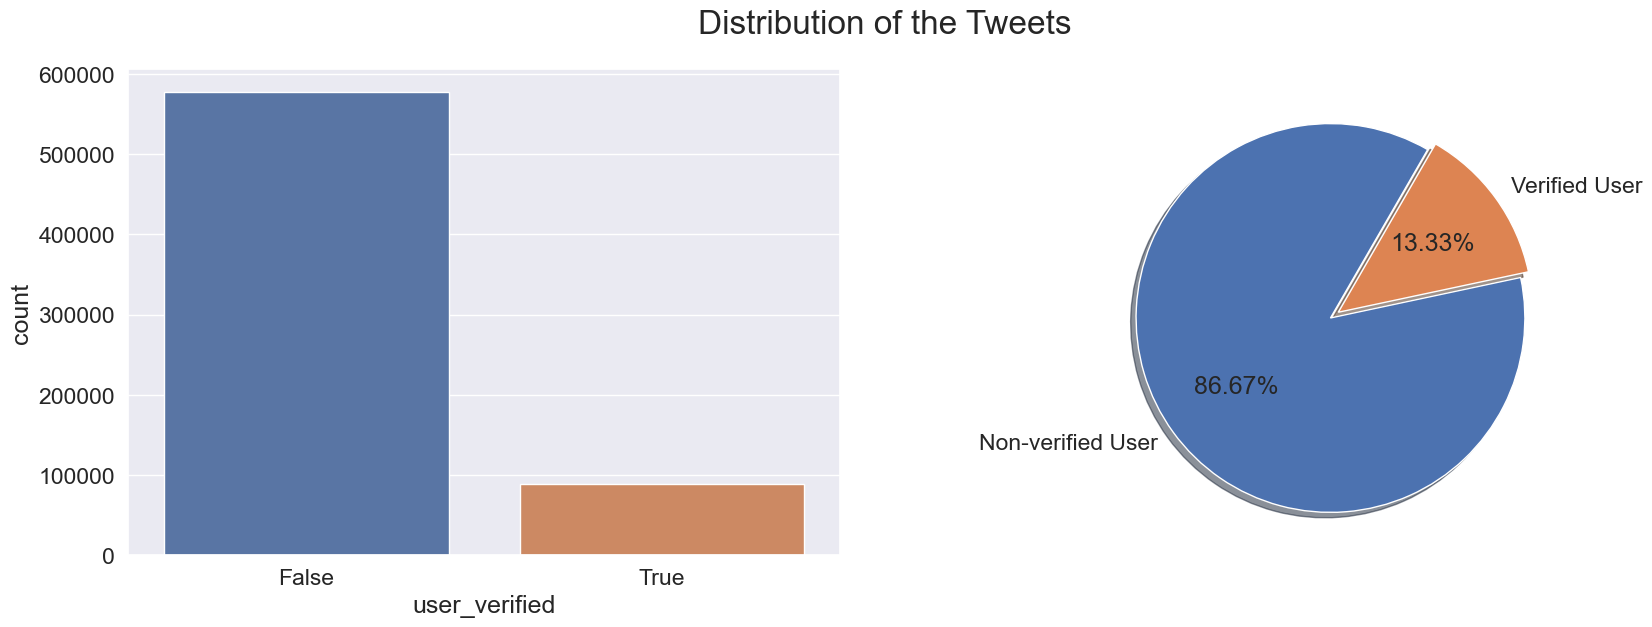

In [78]:
# Displaying target distribution.

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), dpi=100)
sns.countplot(train['user_verified'], ax=axes[0])
axes[1].pie(train['user_verified'].value_counts(),
            labels=['Non-verified User', 'Verified User'],
            autopct='%1.2f%%',
            shadow=True,
            explode=(0.05, 0),
            startangle=60)
fig.suptitle('Distribution of the Tweets', fontsize=24)
plt.show()

**Comment:**
    
> - We can see that the dataset is clearly unbalanced with respect to user verified account.

### Sorting According to Different Columns

In [83]:
sorted_followers = train.sort_values(by=['user_followers_count'], ascending = False)
sorted_followers.head(n=5)

,id,timestamp,retweet_count,user_verified,user_statuses_count,user_followers_count,user_friends_count,user_mentions,urls,hashtags,text
308445,308445,1588709550016,37549,True,15795,117064033,606798,NaN,twitter.com/i/web/status/1…,NaN,No one should be forced to choose between thei...
529350,529350,1588703408686,42851,True,15795,117059317,606799,SenWarren,twitter.com/i/web/status/1…,NaN,"As she often does, @SenWarren provides a cogen..."
241246,241246,1588702306684,37942,True,15795,117058583,606797,NaN,twitter.com/i/web/status/1…,NaN,We can't deny that racial and socioeconomic fa...
81059,81059,1588702322952,93528,True,15795,117058323,606799,NaN,twitter.com/i/web/status/1…,NaN,We owe a profound debt of gratitude to all our...
40881,40881,1588702286963,6461,True,15795,117058259,606799,"rgay, SheaSerrano",twitter.com/i/web/status/1…,NaN,.@rgay and @SheaSerrano are using their feeds ...


In [85]:
sorted_retweets = train.sort_values(by=['retweet_count'], ascending = False)
sorted_retweets.head(n=5)

,id,timestamp,retweet_count,user_verified,user_statuses_count,user_followers_count,user_friends_count,user_mentions,urls,hashtags,text
546442,546442,1588599747040,942572,True,12256,25441659,133,NaN,NaN,NaN,Never Not 💜 https://t.co/Ag9oUTJvrN
565532,565532,1588287503976,647993,True,11599,27641492,824,NaN,NaN,NaN,To all the little girls watching...never doubt...
225845,225845,1588599467583,636394,True,12256,25441494,133,NaN,NaN,NaN,☺ https://t.co/9vNeJtA1vW
117825,117825,1588305672852,415787,False,1956,14783,1530,NaN,NaN,NaN,Easily one of the best social distancing ads I...
622524,622524,1588611150023,334427,True,4622,5313436,26,NaN,NaN,NaN,"I can’t believe I have to say this, but please..."


**Comment:**
> - Most the tweeters who has the biggest number of retweets does not have big number of followers, which means that it depends clearly on the text tweeted (trendy topic maybe).

No handles with labels found to put in legend.


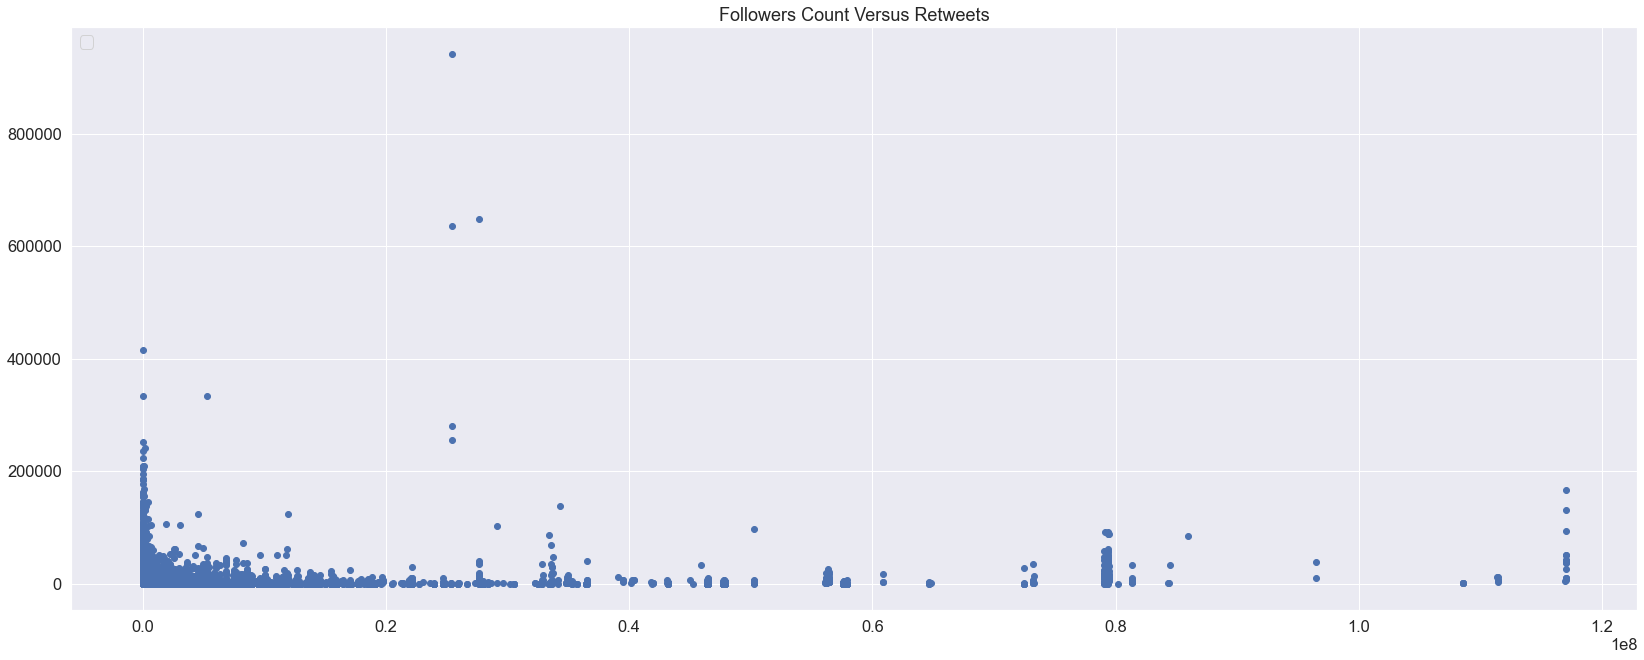

In [91]:
fig, ax = plt.subplots(1, 1, figsize=(25, 10))

ax.plot(train['user_followers_count'], train['retweet_count'],'bo')
#ax[0].plot(descriptors_one[0], descriptors_one[1], 'go', label="One Desciptors")
ax.set_title("Followers Count Versus Retweets")
ax.legend(loc='upper left', frameon=True)

plt.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


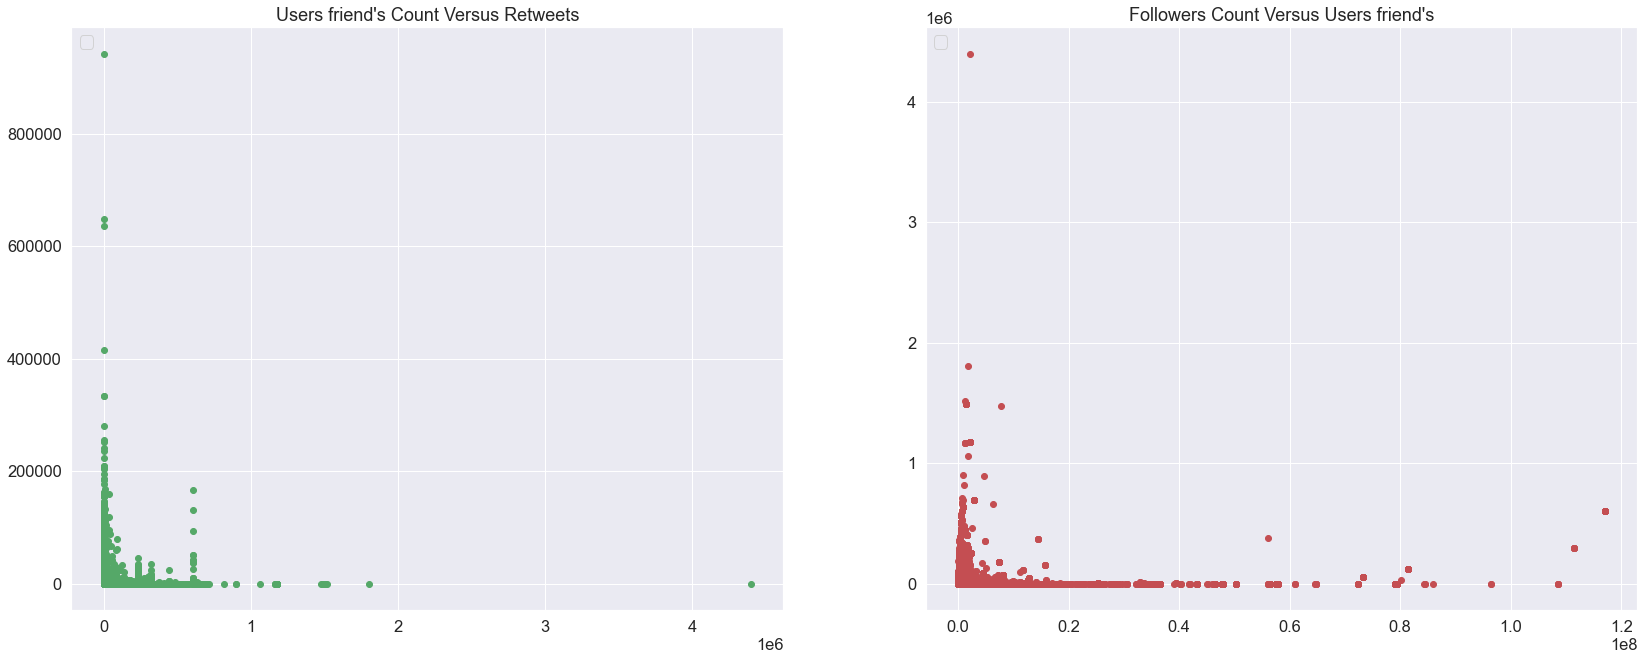

In [92]:
fig, ax = plt.subplots(1, 2, figsize=(25, 10))
ax[0].plot(train["user_friends_count"], train['retweet_count'],'go')
#ax[1].plot(descriptors_one1[0], descriptors_one1[1], 'go', label="One Desciptors")
ax[0].set_title("Users friend's Count Versus Retweets")
ax[0].legend(loc='upper left', frameon=True)

ax[1].plot(train['user_followers_count'], train["user_friends_count"],'ro')
#ax[1].plot(descriptors_one2[0], descriptors_one2[1], 'go', label="One Desciptors")
ax[1].set_title("Followers Count Versus Users friend's")
ax[1].legend(loc='upper left', frameon=True)

plt.show()

**Comment:**
    
> - We can see that the dataset is clearly unbalanced where most of the users has 0 re-tweets.

#### Undersampling

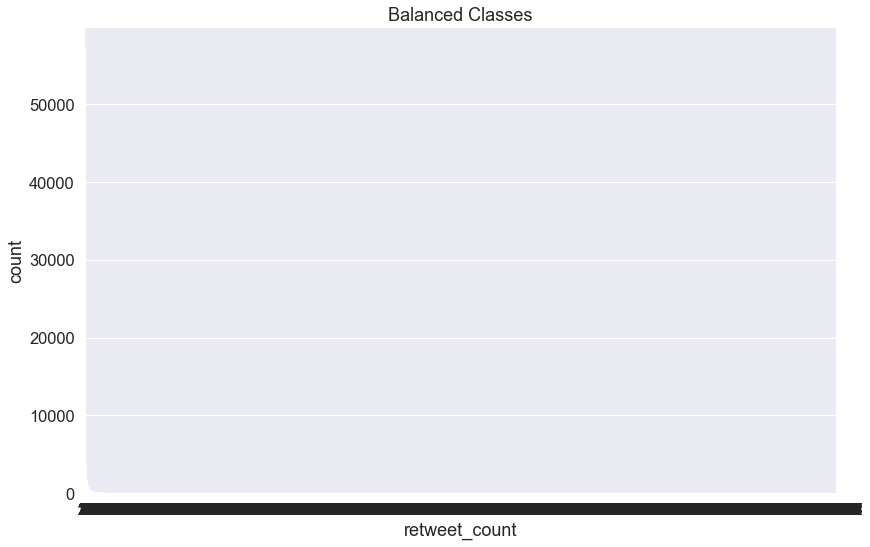

In [95]:
# Shuffle the Dataset.
shuffled_train = train.sample(frac=1,random_state=4)

# Put all the samples where they dont have zeros re-tweet in a separate dataset.
non_zero_retweet = shuffled_train.loc[shuffled_train['retweet_count'] != 0]

#Randomly select 492 observations from the zero re-tweet (majority class)
zero_retweet = shuffled_train.loc[shuffled_train['retweet_count'] == 0].sample(n=492,random_state=42)

# Concatenate both dataframes again
normalized_train = pd.concat([non_zero_retweet, zero_retweet])

#plot the dataset after the undersampling
plt.figure(figsize=(12, 8))
sns.countplot('retweet_count', data=normalized_train)
plt.title('Balanced Classes')
plt.show()

In [97]:
normalized_train.shape

(243466, 11)

--------------------------------------------------------------------------------------------------------

### Cleaning Dataset

In order to clean the dataset, what we have to:
> 1- Removed urls, emojis, html tags and punctuations.

> 2- Tokenized the tweet base texts.

> 3- Lower cased clean text.

> 4- Removed stopwords.

> 5- Applied part of speech tags.

> 6- Converted part of speeches to wordnet format.

> 7- Applying word lemmatizer.

> 8- Converted tokenized text to string again.

In [16]:
# Some basic helper functions to clean text by removing urls, emojis, html tags and punctuations.

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

In [20]:
# Applying helper functions
train_clean = train.copy()
train_clean['text'] = train['text'].apply(lambda x: remove_URL(x))
train_clean['text'] = train['text'].apply(lambda x: remove_emoji(x))
train_clean['text'] = train['text'].apply(lambda x: remove_html(x))
train_clean['text'] = train['text'].apply(lambda x: remove_punct(x))

In [21]:
# Tokenizing the tweet base texts.

train_clean['tokenized'] = train_clean['text'].apply(word_tokenize)

train_clean.head()

,id,timestamp,retweet_count,user_verified,user_statuses_count,user_followers_count,user_friends_count,user_mentions,urls,hashtags,text,tokenized
0,0,1588696955143,0,False,68460,1101,1226,NaN,NaN,NaN,Smh I give up,"[Smh, I, give, up]"
1,1,1588464948124,0,False,309,51,202,NaN,NaN,NaN,Most of us are Human Beings but I think you mi...,"[Most, of, us, are, Human, Beings, but, I, thi..."
2,2,1588634673360,0,False,3241,1675,2325,NaN,NaN,NaN,Old dirty tricks Trump at it againlike we dont...,"[Old, dirty, tricks, Trump, at, it, againlike,..."
3,3,1588433158672,0,False,32327,667,304,NaN,NaN,NaN,Seriously I worked 86 hours my last check and ...,"[Seriously, I, worked, 86, hours, my, last, ch..."
4,4,1588582751599,0,False,581,42,127,NaN,NaN,NaN,May ALMIGHTY ALLAH have mercy on us all Only l...,"[May, ALMIGHTY, ALLAH, have, mercy, on, us, al..."


In [22]:
# Lower casing clean text.

train_clean['lower'] = train_clean['tokenized'].apply(
    lambda x: [word.lower() for word in x])

train_clean.head()

,id,timestamp,retweet_count,user_verified,user_statuses_count,user_followers_count,user_friends_count,user_mentions,urls,hashtags,text,tokenized,lower
0,0,1588696955143,0,False,68460,1101,1226,NaN,NaN,NaN,Smh I give up,"[Smh, I, give, up]","[smh, i, give, up]"
1,1,1588464948124,0,False,309,51,202,NaN,NaN,NaN,Most of us are Human Beings but I think you mi...,"[Most, of, us, are, Human, Beings, but, I, thi...","[most, of, us, are, human, beings, but, i, thi..."
2,2,1588634673360,0,False,3241,1675,2325,NaN,NaN,NaN,Old dirty tricks Trump at it againlike we dont...,"[Old, dirty, tricks, Trump, at, it, againlike,...","[old, dirty, tricks, trump, at, it, againlike,..."
3,3,1588433158672,0,False,32327,667,304,NaN,NaN,NaN,Seriously I worked 86 hours my last check and ...,"[Seriously, I, worked, 86, hours, my, last, ch...","[seriously, i, worked, 86, hours, my, last, ch..."
4,4,1588582751599,0,False,581,42,127,NaN,NaN,NaN,May ALMIGHTY ALLAH have mercy on us all Only l...,"[May, ALMIGHTY, ALLAH, have, mercy, on, us, al...","[may, almighty, allah, have, mercy, on, us, al..."


In [28]:
# Removing stopwords.

train_clean['stopwords_removed'] = train_clean['lower'].apply(
    lambda x: [word for word in x if word not in stop])

train_clean.head()

,id,timestamp,retweet_count,user_verified,user_statuses_count,user_followers_count,user_friends_count,user_mentions,urls,hashtags,text,tokenized,lower,Character Count,stopwords_removed
0,0,1588696955143,0,False,68460,1101,1226,NaN,NaN,NaN,Smh I give up,"[Smh, I, give, up]","[smh, i, give, up]",13,"[smh, give]"
1,1,1588464948124,0,False,309,51,202,NaN,NaN,NaN,Most of us are Human Beings but I think you mi...,"[Most, of, us, are, Human, Beings, but, I, thi...","[most, of, us, are, human, beings, but, i, thi...",65,"[us, human, beings, think, miss, boat, george]"
2,2,1588634673360,0,False,3241,1675,2325,NaN,NaN,NaN,Old dirty tricks Trump at it againlike we dont...,"[Old, dirty, tricks, Trump, at, it, againlike,...","[old, dirty, tricks, trump, at, it, againlike,...",93,"[old, dirty, tricks, trump, againlike, dont, k..."
3,3,1588433158672,0,False,32327,667,304,NaN,NaN,NaN,Seriously I worked 86 hours my last check and ...,"[Seriously, I, worked, 86, hours, my, last, ch...","[seriously, i, worked, 86, hours, my, last, ch...",79,"[seriously, worked, 86, hours, last, check, ’,..."
4,4,1588582751599,0,False,581,42,127,NaN,NaN,NaN,May ALMIGHTY ALLAH have mercy on us all Only l...,"[May, ALMIGHTY, ALLAH, have, mercy, on, us, al...","[may, almighty, allah, have, mercy, on, us, al...",88,"[may, almighty, allah, mercy, us, lagosians, o..."


In [29]:
# Applying part of speech tags.

train_clean['pos_tags'] = train_clean['stopwords_removed'].apply(nltk.tag.pos_tag)

train_clean.head()

,id,timestamp,retweet_count,user_verified,user_statuses_count,user_followers_count,user_friends_count,user_mentions,urls,hashtags,text,tokenized,lower,Character Count,stopwords_removed,pos_tags
0,0,1588696955143,0,False,68460,1101,1226,NaN,NaN,NaN,Smh I give up,"[Smh, I, give, up]","[smh, i, give, up]",13,"[smh, give]","[(smh, NNS), (give, VBP)]"
1,1,1588464948124,0,False,309,51,202,NaN,NaN,NaN,Most of us are Human Beings but I think you mi...,"[Most, of, us, are, Human, Beings, but, I, thi...","[most, of, us, are, human, beings, but, i, thi...",65,"[us, human, beings, think, miss, boat, george]","[(us, PRP), (human, JJ), (beings, NNS), (think..."
2,2,1588634673360,0,False,3241,1675,2325,NaN,NaN,NaN,Old dirty tricks Trump at it againlike we dont...,"[Old, dirty, tricks, Trump, at, it, againlike,...","[old, dirty, tricks, trump, at, it, againlike,...",93,"[old, dirty, tricks, trump, againlike, dont, k...","[(old, JJ), (dirty, NN), (tricks, NNS), (trump..."
3,3,1588433158672,0,False,32327,667,304,NaN,NaN,NaN,Seriously I worked 86 hours my last check and ...,"[Seriously, I, worked, 86, hours, my, last, ch...","[seriously, i, worked, 86, hours, my, last, ch...",79,"[seriously, worked, 86, hours, last, check, ’,...","[(seriously, RB), (worked, VBD), (86, CD), (ho..."
4,4,1588582751599,0,False,581,42,127,NaN,NaN,NaN,May ALMIGHTY ALLAH have mercy on us all Only l...,"[May, ALMIGHTY, ALLAH, have, mercy, on, us, al...","[may, almighty, allah, have, mercy, on, us, al...",88,"[may, almighty, allah, mercy, us, lagosians, o...","[(may, MD), (almighty, VB), (allah, NN), (merc..."


In [30]:
# Converting part of speeches to wordnet format.

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [31]:
train_clean['wordnet_pos'] = train_clean['pos_tags'].apply(
    lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

train_clean.head()

,id,timestamp,retweet_count,user_verified,user_statuses_count,user_followers_count,user_friends_count,user_mentions,urls,hashtags,text,tokenized,lower,Character Count,stopwords_removed,pos_tags,wordnet_pos
0,0,1588696955143,0,False,68460,1101,1226,NaN,NaN,NaN,Smh I give up,"[Smh, I, give, up]","[smh, i, give, up]",13,"[smh, give]","[(smh, NNS), (give, VBP)]","[(smh, n), (give, v)]"
1,1,1588464948124,0,False,309,51,202,NaN,NaN,NaN,Most of us are Human Beings but I think you mi...,"[Most, of, us, are, Human, Beings, but, I, thi...","[most, of, us, are, human, beings, but, i, thi...",65,"[us, human, beings, think, miss, boat, george]","[(us, PRP), (human, JJ), (beings, NNS), (think...","[(us, n), (human, a), (beings, n), (think, v),..."
2,2,1588634673360,0,False,3241,1675,2325,NaN,NaN,NaN,Old dirty tricks Trump at it againlike we dont...,"[Old, dirty, tricks, Trump, at, it, againlike,...","[old, dirty, tricks, trump, at, it, againlike,...",93,"[old, dirty, tricks, trump, againlike, dont, k...","[(old, JJ), (dirty, NN), (tricks, NNS), (trump...","[(old, a), (dirty, n), (tricks, n), (trump, v)..."
3,3,1588433158672,0,False,32327,667,304,NaN,NaN,NaN,Seriously I worked 86 hours my last check and ...,"[Seriously, I, worked, 86, hours, my, last, ch...","[seriously, i, worked, 86, hours, my, last, ch...",79,"[seriously, worked, 86, hours, last, check, ’,...","[(seriously, RB), (worked, VBD), (86, CD), (ho...","[(seriously, r), (worked, v), (86, n), (hours,..."
4,4,1588582751599,0,False,581,42,127,NaN,NaN,NaN,May ALMIGHTY ALLAH have mercy on us all Only l...,"[May, ALMIGHTY, ALLAH, have, mercy, on, us, al...","[may, almighty, allah, have, mercy, on, us, al...",88,"[may, almighty, allah, mercy, us, lagosians, o...","[(may, MD), (almighty, VB), (allah, NN), (merc...","[(may, n), (almighty, v), (allah, n), (mercy, ..."


In [32]:
# Applying word lemmatizer.

wnl = WordNetLemmatizer()

train_clean['lemmatized'] = train_clean['wordnet_pos'].apply(
    lambda x: [wnl.lemmatize(word, tag) for word, tag in x])

train_clean['lemmatized'] = train_clean['lemmatized'].apply(
    lambda x: [word for word in x if word not in stop])

train_clean['lemma_str'] = [' '.join(map(str, l)) for l in train_clean['lemmatized']]

train_clean.head()

,id,timestamp,retweet_count,user_verified,user_statuses_count,user_followers_count,user_friends_count,user_mentions,urls,hashtags,text,tokenized,lower,Character Count,stopwords_removed,pos_tags,wordnet_pos,lemmatized,lemma_str
0,0,1588696955143,0,False,68460,1101,1226,NaN,NaN,NaN,Smh I give up,"[Smh, I, give, up]","[smh, i, give, up]",13,"[smh, give]","[(smh, NNS), (give, VBP)]","[(smh, n), (give, v)]","[smh, give]",smh give
1,1,1588464948124,0,False,309,51,202,NaN,NaN,NaN,Most of us are Human Beings but I think you mi...,"[Most, of, us, are, Human, Beings, but, I, thi...","[most, of, us, are, human, beings, but, i, thi...",65,"[us, human, beings, think, miss, boat, george]","[(us, PRP), (human, JJ), (beings, NNS), (think...","[(us, n), (human, a), (beings, n), (think, v),...","[u, human, think, miss, boat, george]",u human think miss boat george
2,2,1588634673360,0,False,3241,1675,2325,NaN,NaN,NaN,Old dirty tricks Trump at it againlike we dont...,"[Old, dirty, tricks, Trump, at, it, againlike,...","[old, dirty, tricks, trump, at, it, againlike,...",93,"[old, dirty, tricks, trump, againlike, dont, k...","[(old, JJ), (dirty, NN), (tricks, NNS), (trump...","[(old, a), (dirty, n), (tricks, n), (trump, v)...","[old, dirty, trick, trump, againlike, dont, kn...",old dirty trick trump againlike dont know fauc...
3,3,1588433158672,0,False,32327,667,304,NaN,NaN,NaN,Seriously I worked 86 hours my last check and ...,"[Seriously, I, worked, 86, hours, my, last, ch...","[seriously, i, worked, 86, hours, my, last, ch...",79,"[seriously, worked, 86, hours, last, check, ’,...","[(seriously, RB), (worked, VBD), (86, CD), (ho...","[(seriously, r), (worked, v), (86, n), (hours,...","[seriously, work, 86, hour, last, check, ’, ev...",seriously work 86 hour last check ’ even come ...
4,4,1588582751599,0,False,581,42,127,NaN,NaN,NaN,May ALMIGHTY ALLAH have mercy on us all Only l...,"[May, ALMIGHTY, ALLAH, have, mercy, on, us, al...","[may, almighty, allah, have, mercy, on, us, al...",88,"[may, almighty, allah, mercy, us, lagosians, o...","[(may, MD), (almighty, VB), (allah, NN), (merc...","[(may, n), (almighty, v), (allah, n), (mercy, ...","[may, almighty, allah, mercy, u, lagosians, ob...",may almighty allah mercy u lagosians observed ...


In [34]:
#Convert boolean variables into int (Verified/Non-verified account)
train_clean["user_verified"] = train_clean["user_verified"].astype(int)

In [52]:
counter_user_text = train['text'].isnull().sum()
counter_user_mentions = train['user_mentions'].isnull().sum()
counter_urls = train['urls'].isnull().sum()
counter_hashtags = train['hashtags'].isnull().sum()    

In [53]:
print("\t Text column NULL entries: ", counter_user_text)
print("\t User_mentions column NULL entries: ", counter_user_mentions)
print("\t Urls column column NULL entries: ", counter_urls)
print("\t Hashtags column NULL entries: ", counter_hashtags)
print("\t Number of row: ", len(train_clean.index))

	 Text column NULL entries:  0
	 User_mentions column NULL entries:  611486
	 Urls column column NULL entries:  451697
	 Hashtags column NULL entries:  593326
	 Number of row:  665777


In [39]:
train_clean.drop('timestamp', axis=1, inplace=True)
train_clean.drop('user_mentions', axis=1, inplace=True)
train_clean.drop('urls', axis=1, inplace=True)
train_clean.drop('hashtags', axis=1, inplace=True)

--------------------------------------------------------------------------------------------------

### Data Visualization

Our text is ready for inspection, clean and in order. We can start visualizing the data to see if we can get some insights from the tweets.

> - Intuitions we would like to investigate:
>> - We know that verified persons on twitter are politicians, govenors, and start, and are those who tweet mostly a lot and has a lot of followers, which might lead that their tweets get re-tweeted a lot.
>> - Thoughout, this section we would like to investigate that given the dataset we have.
>> - In order to see, what are the most discussed subjects, and used words in their tweets

In [42]:
# For customizing our plots.

from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

train_clean['Character Count'] = train_clean['text'].apply(lambda x: len(str(x)))


def plot_dist3(df, feature, title):
    # Creating a customized chart. and giving in figsize and everything.
    fig = plt.figure(constrained_layout=True, figsize=(18, 8))
    # Creating a grid of 3 cols and 3 rows.
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

    # Customizing the histogram grid.
    ax1 = fig.add_subplot(grid[0, :2])
    # Set the title.
    ax1.set_title('Histogram')
    # plot the histogram.
    sns.distplot(df.loc[:, feature],
                 hist=True,
                 kde=True,
                 ax=ax1,
                 color='#e74c3c')
    ax1.set(ylabel='Frequency')
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=20))

    # Customizing the ecdf_plot.
    ax2 = fig.add_subplot(grid[1, :2])
    # Set the title.
    ax2.set_title('Empirical CDF')
    # Plotting the ecdf_Plot.
    sns.distplot(df.loc[:, feature],
                 ax=ax2,
                 kde_kws={'cumulative': True},
                 hist_kws={'cumulative': True},
                 color='#e74c3c')
    ax2.xaxis.set_major_locator(MaxNLocator(nbins=20))
    ax2.set(ylabel='Cumulative Probability')

    # Customizing the Box Plot.
    ax3 = fig.add_subplot(grid[:, 2])
    # Set title.
    ax3.set_title('Box Plot')
    # Plotting the box plot.
    sns.boxplot(x=feature, data=df, orient='v', ax=ax3, color='#e74c3c')
    ax3.yaxis.set_major_locator(MaxNLocator(nbins=25))

    plt.suptitle(f'{title}', fontsize=24)

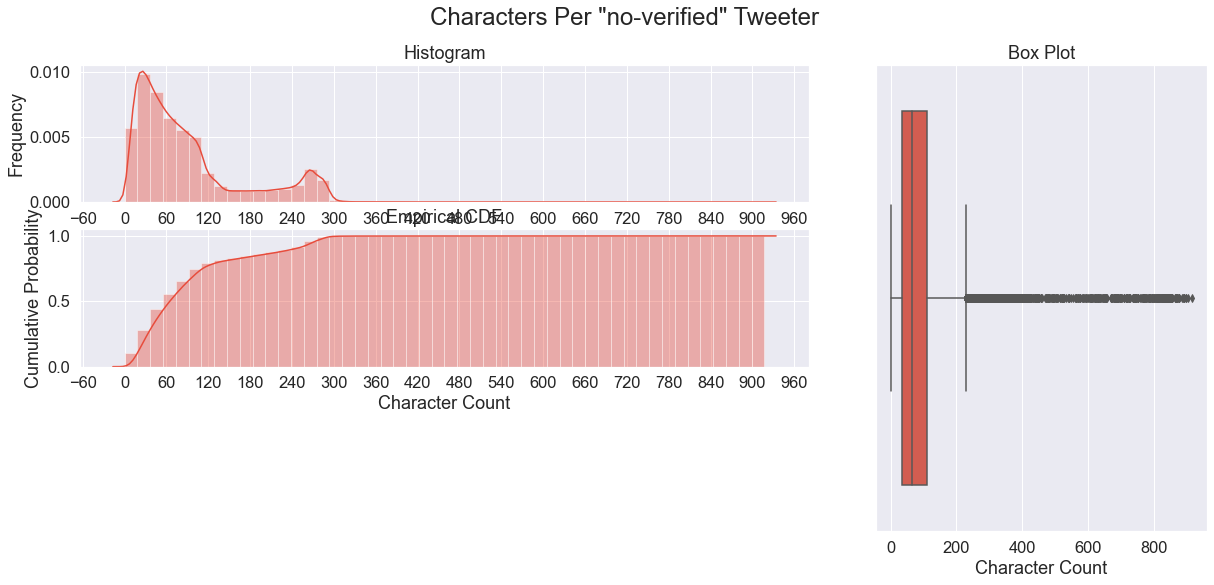

In [43]:
plot_dist3(train_clean[train_clean['user_verified'] == 0], 'Character Count',
           'Characters Per "no-verified" Tweeter')

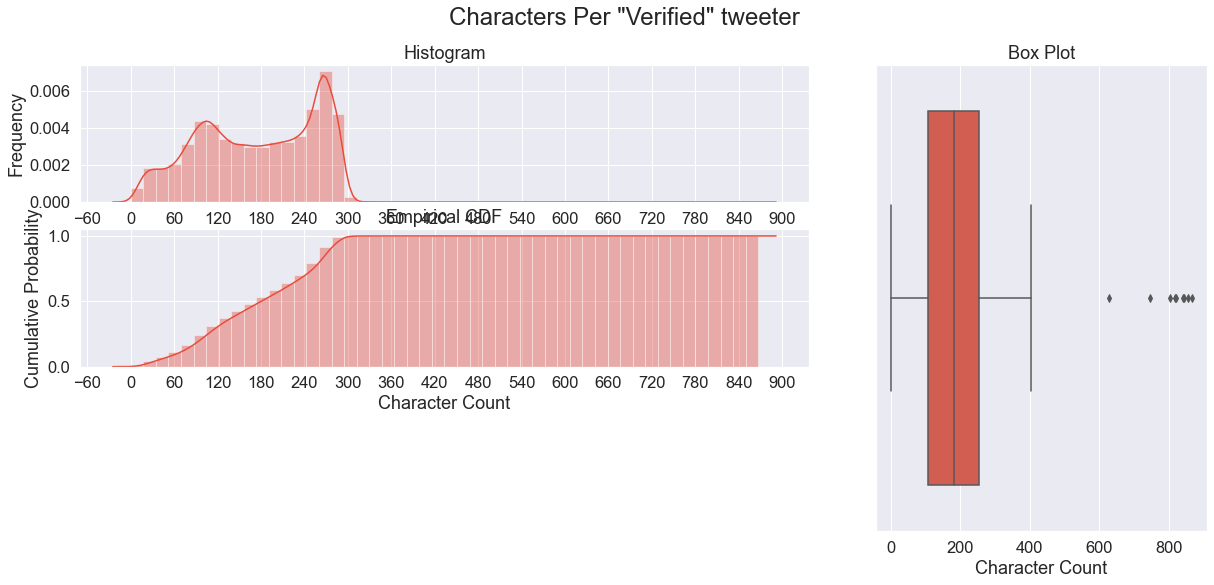

In [44]:
plot_dist3(train_clean[train_clean['user_verified'] == 1], 'Character Count',
           'Characters Per "Verified" tweeter')

In [47]:
def plot_word_number_histogram(textno, textye):
    
    """A function for comparing word counts"""

    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), sharey=True)
    sns.distplot(textno.str.split().map(lambda x: len(x)), ax=axes[0], color='#e74c3c')
    sns.distplot(textye.str.split().map(lambda x: len(x)), ax=axes[1], color='#e74c3c')
    
    axes[0].set_xlabel('Word Count')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Non-Verified Tweeter')
    axes[1].set_xlabel('Word Count')
    axes[1].set_title('Verified Tweeter')
    
    fig.suptitle('Words Per Tweet', fontsize=24, va='baseline')
    
    fig.tight_layout()

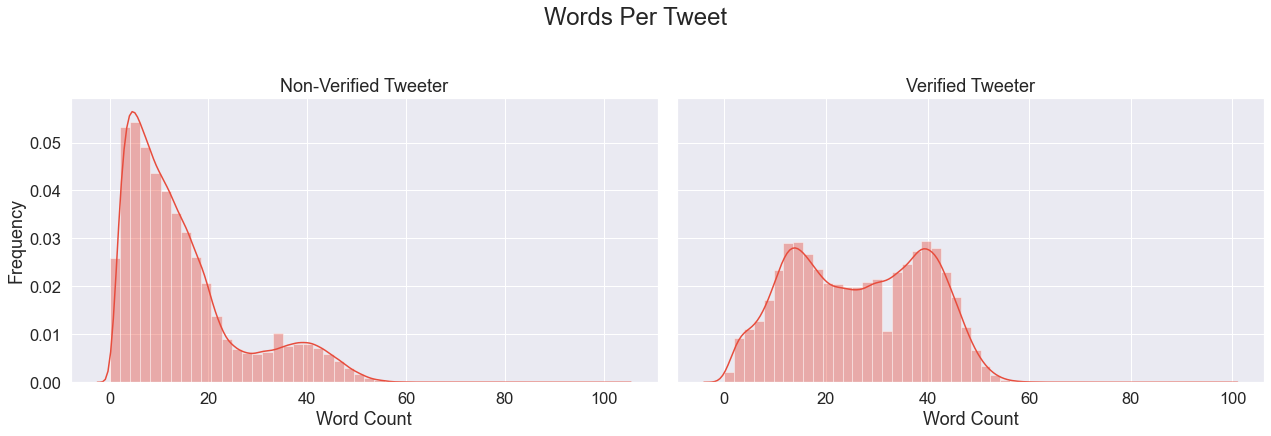

In [48]:
plot_word_number_histogram(train_clean[train_clean['user_verified'] == 0]['text'],
                           train_clean[train_clean['user_verified'] == 1]['text'])

In [54]:
lis = [
    train_clean[train_clean['user_verified'] == 0]['lemma_str'],
    train_clean[train_clean['user_verified'] == 1]['lemma_str']
]

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes = axes.flatten()

for i, j in zip(lis, axes):
    try:
        new = i.str.split()
        new = new.values.tolist()
        corpus = [word.lower() for i in new for word in i]
        dic = defaultdict(int)
        for word in corpus:
            if word in stop:
                dic[word] += 1

        top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:15]
        x, y = zip(*top)
        df = pd.DataFrame([x, y]).T
        df = df.rename(columns={0: 'Stopword', 1: 'Count'})
        sns.barplot(x='Count', y='Stopword', data=df, palette='plasma', ax=j)
        plt.tight_layout()
    except:
        plt.close()
        print('No stopwords left in texts.')
        break

No stopwords left in texts.


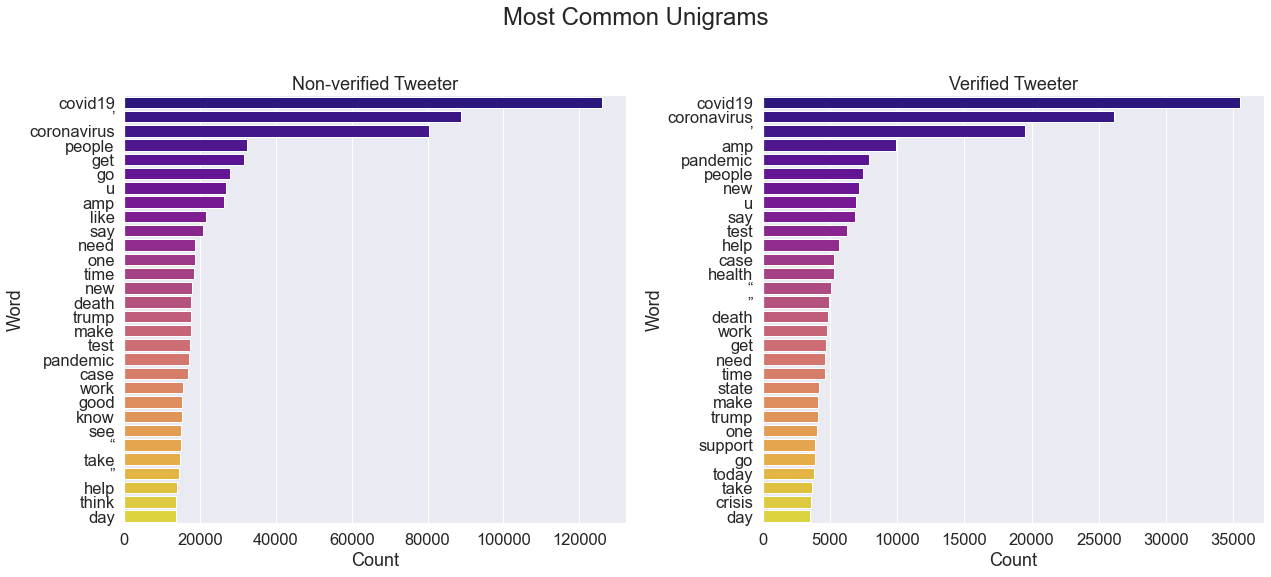

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes = axes.flatten()

for i, j in zip(lis, axes):

    new = i.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []
    for word, count in most[:30]:
        if (word not in stop):
            x.append(word)
            y.append(count)

    sns.barplot(x=y, y=x, palette='plasma', ax=j)
axes[0].set_title('Non-verified Tweeter')
axes[1].set_title('Verified Tweeter')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Word')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Word')

fig.suptitle('Most Common Unigrams', fontsize=24, va='baseline')
plt.tight_layout()

In [58]:
def ngrams(n, title):
    """A Function to plot most common ngrams"""
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    axes = axes.flatten()
    for i, j in zip(lis, axes):

        new = i.str.split()
        new = new.values.tolist()
        corpus = [word for i in new for word in i]

        def _get_top_ngram(corpus, n=None):
            #getting top ngrams
            vec = CountVectorizer(ngram_range=(n, n),
                                  max_df=0.9,
                                  stop_words='english').fit(corpus)
            bag_of_words = vec.transform(corpus)
            sum_words = bag_of_words.sum(axis=0)
            words_freq = [(word, sum_words[0, idx])
                          for word, idx in vec.vocabulary_.items()]
            words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
            return words_freq[:15]

        top_n_bigrams = _get_top_ngram(i, n)[:15]
        x, y = map(list, zip(*top_n_bigrams))
        sns.barplot(x=y, y=x, palette='plasma', ax=j)
        
        axes[1].set_title('Verified Tweeter')
        axes[0].set_title('Non-verified Tweeter')
        axes[0].set_xlabel('Count')
        axes[0].set_ylabel('Words')
        axes[1].set_xlabel('Count')
        axes[1].set_ylabel('Words')
        fig.suptitle(title, fontsize=24, va='baseline')
        plt.tight_layout()

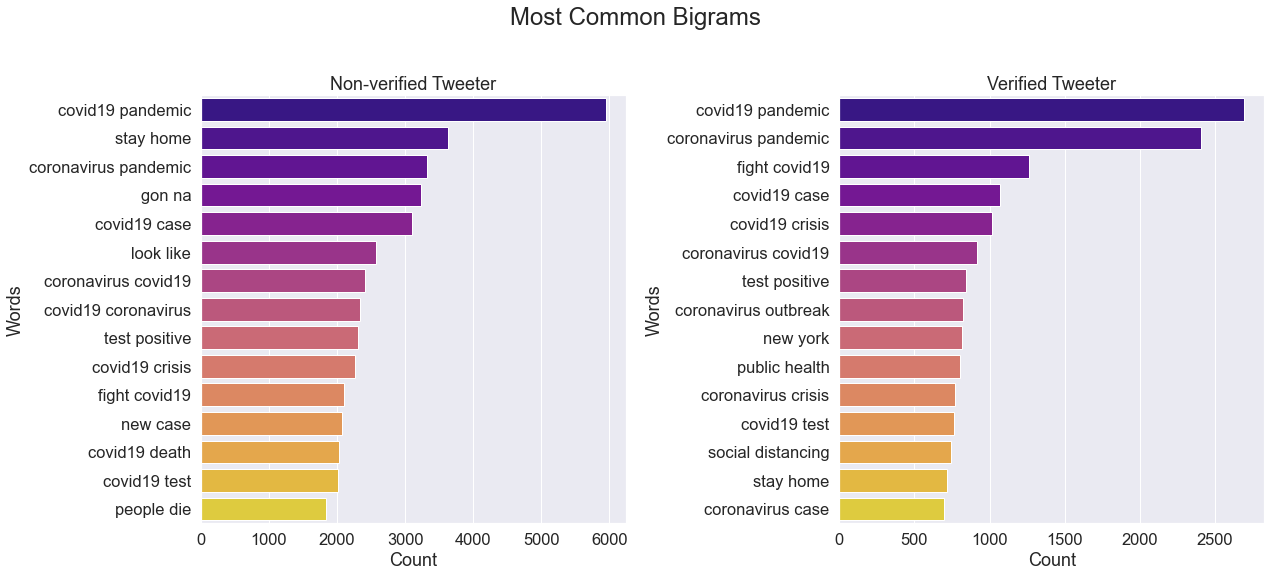

In [59]:
ngrams(2, 'Most Common Bigrams')

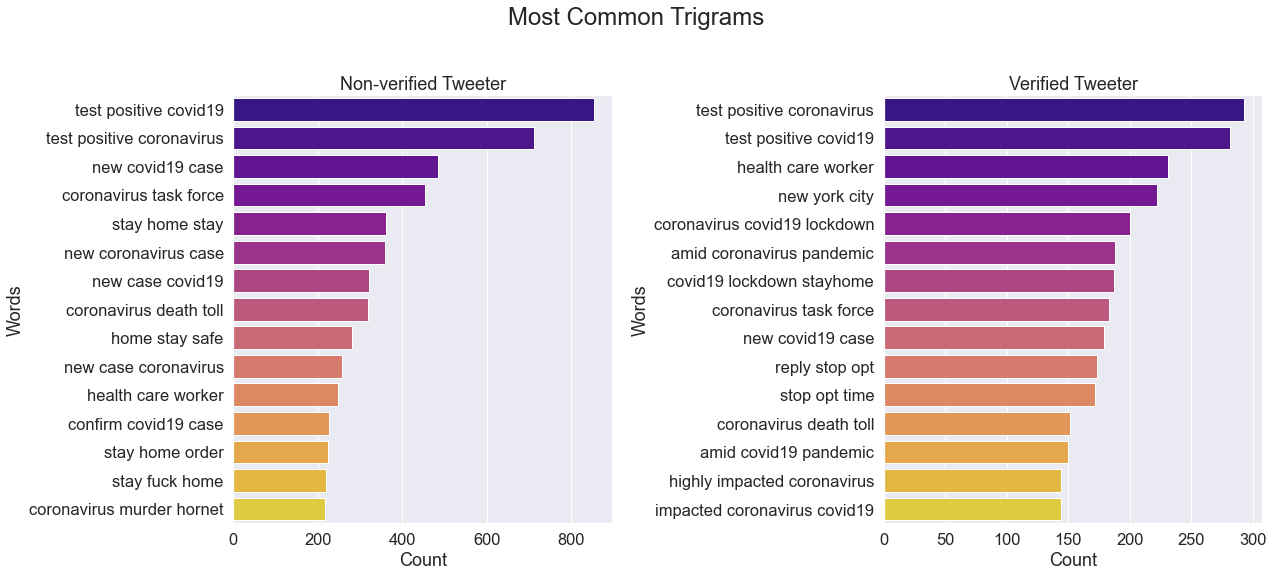

In [60]:
ngrams(3, 'Most Common Trigrams')